In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from uncertainties import ufloat
from uncertainties import nominal_value as nom

In [2]:
# B im Delay, messdauer = 20 s
B   = np.array((0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 10, 12, 16)) # ns
C_B = np.array((262, 237, 267, 338, 266, 223, 210, 235, 206, 205, 184, 173, 203, 184, 153, 162, 97 ,  21,  77, 62, 16,  6)) # num

# A im Delay, messdauer = 20 s
A   = np.array((0,   0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 7.0, 8.0, 9.0, 10.0, 12.0, 16.0)) # ns
C_A = np.array((290, 318, 324, 271, 246, 235, 232, 208, 189, 167, 133, 125, 105,  76,  42,  53,   46,   17,   18)) # num


a, x0, sigma
284+/-8 0.65+/-0.18 5.07+/-0.20
fwhm =  11.9+/-0.5


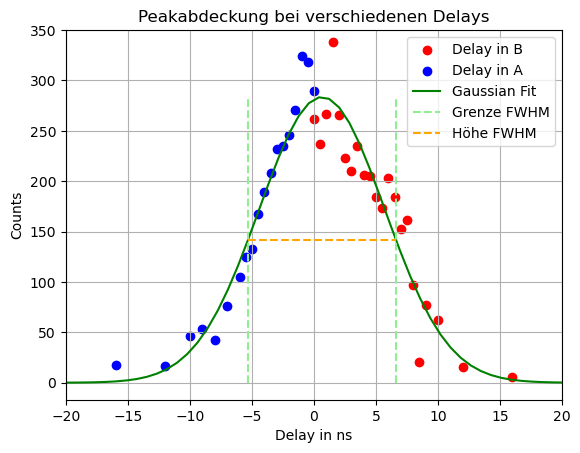

In [ ]:
def gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

x = np.concatenate((-A, B))
y = np.concatenate((C_A, C_B))

popt, pcov = curve_fit(gauss, x, y)

a = ufloat(popt[0], np.sqrt(np.diag(pcov))[0])
x0 = ufloat(popt[1], np.sqrt(np.diag(pcov))[1])
sigma = ufloat(popt[2], np.sqrt(np.diag(pcov))[2])
print("a, x0, sigma")
print(a, x0, sigma)

fwhm = 2*np.sqrt(2*np.log(2)) * (sigma)
print("fwhm breite = ", fwhm)
xx = np.linspace(-20, 20)


plt.scatter(B, C_B, color="red", label="Delay in B")
plt.scatter(-A, C_A, color="blue", label="Delay in A")

plt.plot(xx, gauss(xx, *popt), label="Gaussian Fit", color="green")

plt.vlines([nom(x0 - fwhm/2), nom(x0 + fwhm/2)], 0, nom(a), linestyles="dashed", color="lightgreen", label="Grenze FWHM")
plt.hlines(nom(a/2), nom(x0 - fwhm/2), nom(x0 + fwhm/2), linestyles="dashed", color="orange", label="Höhe FWHM")

plt.xlabel("Delay in ns")
plt.xlim(-20, 20)
plt.ylabel("Counts")
plt.ylim(top=350)
plt.grid("on")
plt.title("Peakabdeckung bei verschiedenen Delays")

plt.legend()

[0.02170014 0.15770793]
[1.47877264e-05 3.50149972e-03]


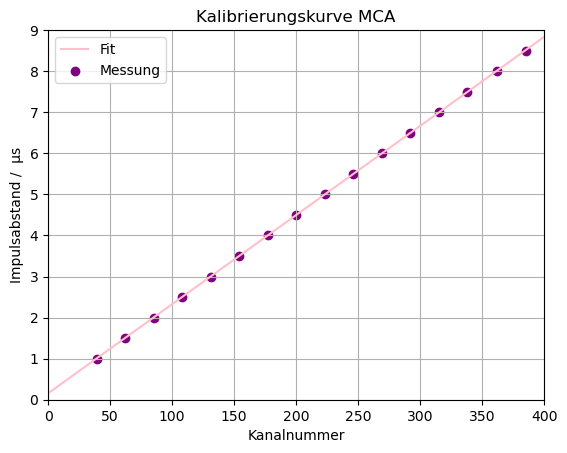

In [4]:
# doppelimpulsgenrator MCA kalibrierung

impulsabstand = 0.1*np.array((10, 15, 20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,  75,  80,  85)) # 0.1 µs
kanalnummer   = np.array((39, 62, 85, 108, 131, 154, 177, 200, 223, 246, 269, 292, 315, 338, 362, 385)) # num

def linfit(x, m, b):
    return m*x+b 

p_cal, cov_cal = curve_fit(linfit, kanalnummer, impulsabstand)

print(p_cal)
print(np.sqrt(np.diag(cov_cal)))

xx = np.linspace(0, 400)
yy = linfit(xx, *p_cal)

plt.plot(xx, yy, color="pink", label="Fit")
plt.scatter(kanalnummer, impulsabstand, color="purple", label="Messung")

plt.xlabel("Kanalnummer")
plt.xlim(0, 400)
plt.ylim(0, 9)
plt.ylabel("Impulsabstand /  µs")
plt.grid("on")
plt.title("Kalibrierungskurve MCA")
plt.legend()

$$
\begin{align}
f(K) &= m * K + b \\
&= (0.021701 \pm 1.4 \cdot 10^{-5}) \frac{\mu s}{\text{Kanalnummer}} \cdot K + (0.1577 \pm 3.5 \cdot 10^{-3}) \mu s
\end{align}
$$